
# Inventory Control Example

This is a great example of using an MDP to define a problem. I intentionally keep it simple to make all the main parts of the MPD clear.

Imagine you own a really simple shop. It sells one product and you have limited room for stock. The question is, when should you restock?

## The Testing Environment

First I'm going to develop an environment to simulate the shop. In this instance I'm going to declare all the transition probabilities myself. Let's start by installing the dependencies (if not already available) and defining some hyper-parameters of the environment.

In [1]:
!pip install pandas==1.1.2 matplotlib==3.3.2 &2> /dev/null

In [2]:
import numpy as np

p_sale = 0.7 # Probability of a sale in one step
n_steps = 100 # Number of steps to run experiment for
np.random.seed(42)

### Actions and Potential Strategies

Next I define the actions of the agent: it can either restock, or do nothing. I also provide some simple strategies in this class: always buy, randomly buy and only buy when there is nothing left in stock.

Note that this is a little contrived. In general, the actions and strategy are completely decoupled. I'm keeping them here for simplicity.

In [3]:
from enum import Enum

class Action(Enum):
    NONE = 0
    RESTOCK = 1

    @staticmethod
    def keep_buying_action(current_state) -> Enum:
        if current_state == 2:
            return Action.NONE
        else:
            return Action.RESTOCK

    @staticmethod
    def random_action(current_state) -> Enum:
        if current_state == 2:
            return Action.NONE
        if np.random.randint(len(Action)) == 0:
            return Action.NONE
        else:
            return Action.RESTOCK

    @staticmethod
    def zero_action(current_state) -> Enum:
        if current_state == 0:
            return Action.RESTOCK
        else:
            return Action.NONE

print("There are {} actions.".format(len(Action)))

There are 2 actions.


### Transition Matrix

Next I'm defining the transition matrix. This is the thing that defines how the environment changes state. Again, typically you would not have access to this. This is purely for simulation.

In [4]:
# The Transition Matrix represents the following states:
# State 0
# State 1
# State 2
transition_matrix = [
    # No action
    [
        [1, 0, 0],
        [p_sale, 1 - p_sale, 0],
        [0, p_sale, 1 - p_sale],
    ],
    # Restock
    [
        [p_sale, 1 - p_sale, 0],
        [0, p_sale, 1 - p_sale],
    ],
]

### Reward Matrix

And finally, I need a reward matrix, to tell the environment how to reward the environment based upon certain actions and states.

In [5]:
reward_matrix = [
    # No action
    [
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
    ],
    # Restock
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ],
]

## Experiment 1: The Environment

To demonstrate how this all fits together, let's imagine a single iteration of the environment. You start with an initial state, feed that to the "agent" to decide an action, then the environment uses the transition matrix to mutate the state and finally it receives a reward. 

Let's create a helper function to do all of that.

In [6]:
def environment(current_state: int, action: int) -> (int, int):
    # Get the transition probabilities to each new state
    current_transition_probabilities = \
        transition_matrix[action.value][current_state]
    
    # Use the transition probabilitis to transition to a new state
    next_state = np.random.choice(
        a=[0, 1, 2],
        p=current_transition_probabilities
    )
    
    # Get the reward for the new state (was there a sale?)
    reward = reward_matrix[action.value][current_state][next_state]
    return (next_state, reward)

current_state = 1 # Current state, one product in stock
action = Action.RESTOCK # Current action, as chosen by a strategy
for i in range(10): # What happens if we run this multiple times?
    next_state, reward = environment(current_state, action) # Environment interface
    print(f"trial {i}: s={current_state}, a={action}, s'={next_state}, r={reward}")

trial 0: s=1, a=Action.RESTOCK, s'=1, r=1
trial 1: s=1, a=Action.RESTOCK, s'=2, r=0
trial 2: s=1, a=Action.RESTOCK, s'=2, r=0
trial 3: s=1, a=Action.RESTOCK, s'=1, r=1
trial 4: s=1, a=Action.RESTOCK, s'=1, r=1
trial 5: s=1, a=Action.RESTOCK, s'=1, r=1
trial 6: s=1, a=Action.RESTOCK, s'=1, r=1
trial 7: s=1, a=Action.RESTOCK, s'=2, r=0
trial 8: s=1, a=Action.RESTOCK, s'=1, r=1
trial 9: s=1, a=Action.RESTOCK, s'=2, r=0


Recall that the sale is a stochastic variable. Sometimes there is, sometimes there is not. When there is no sale, the stock (state) increases to 2, but there is no reward. When there is a sale, the stock (state) states at 1 because we sold one and restocked by one, and receive a reward of 1.

## Experiment 2: Testing Different Restocking Strategies

Now let's run this over a longer period of time, using different strategies. The three strategies I want to try are: always restock, restock when no stock left (just in time), and random restock.

In [7]:
import pandas as pd

# The different strategies
strategies = [("Keep Buying", Action.keep_buying_action),
            ("Upon Zero", Action.zero_action), ("Random", Action.random_action)]
result = [] # Results buffer

for (policy_name, action_getter) in strategies:
    np.random.seed(42) # This is really important, otherwise different strategies will experience sales
    reward_history = [] # Reward buffer
    current_state = 2 # Initial state
    total_reward = 0
    for i in range(n_steps):
        reward_history.append(total_reward)
        action = action_getter(current_state) # Get new action for strategy
        next_state, reward = environment(current_state, action) # Environment interface
        print("Moving from state {} to state {} after action {}. We received the reward {}."
              .format(current_state, next_state, action.name, reward))
        total_reward += reward
        current_state = next_state # Set next state to current state and repeat
    print("The total reward was {}.".format(total_reward))

    # Pandas/plotting stuff
    series = pd.Series(
        reward_history,
        index=range(n_steps),
        name="{} ({})".format(policy_name, total_reward / n_steps))
    result.append(series)
df = pd.concat(result, axis=1)

g from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 2 after action RESTOCK. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward

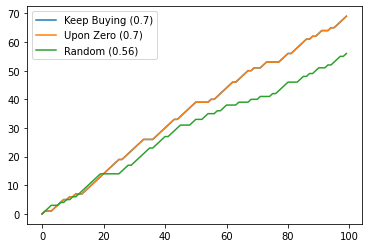

In [8]:
(df).plot();

The restock and just in time curves are overlapping, so let me add a little jitter so you can see them...

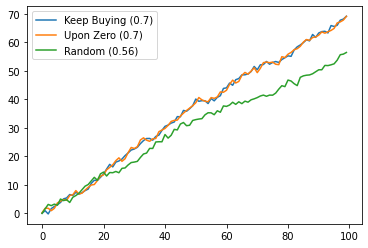

In [9]:
(df + np.random.normal(size=df.shape)*0.5).plot();

So you can see that the always buy and just in time strategies are equivalent, given this reward function. Because holding stock isn't penalised. Obviously this picture would change if we made the simulation more complex.

## Experiment 3: Random Seeds

I'd like to demonstrate what happens when you don't fix the random seeds. Let's run the exact same code again, but this time skip the random seed setting.

In [10]:
import pandas as pd

# The different strategies
strategies = [("Keep Buying", Action.keep_buying_action),
            ("Upon Zero", Action.zero_action), ("Random", Action.random_action)]
result = [] # Results buffer

for (policy_name, action_getter) in strategies:
    # np.random.seed(42) # Commenting this line out!!!
    reward_history = [] # Reward buffer
    current_state = 2 # Initial state
    total_reward = 0
    for i in range(n_steps):
        reward_history.append(total_reward)
        action = action_getter(current_state) # Get new action for strategy
        next_state, reward = environment(current_state, action) # Environment interface
        print("Moving from state {} to state {} after action {}. We received the reward {}."
              .format(current_state, next_state, action.name, reward))
        total_reward += reward
        current_state = next_state # Set next state to current state and repeat
    print("The total reward was {}.".format(total_reward))

    # Pandas/plotting stuff
    series = pd.Series(
        reward_history,
        index=range(n_steps),
        name="{} ({})".format(policy_name, total_reward / n_steps))
    result.append(series)
df = pd.concat(result, axis=1)

n RESTOCK. We received the reward 0.
Moving from state 2 to state 2 after action NONE. We received the reward 0.
Moving from state 2 to state 1 after action NONE. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 to state 1 after action RESTOCK. We received the reward 1.
Moving from state 1 t

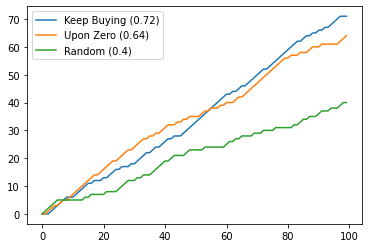

In [11]:
df.plot();

Now look! The strategies appear different. This is because of fluctuations in the probability of making a sale. Random chance might produce no sales for a long period of time and hamper an otherwise sensible strategy.

This is a particularly challenging topic in RL. Most environments are stochastic and algorithms could be too. In general you need to repeat an experiment many times to average out the random effects.